# T-EDA

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout, Flatten, Input, Conv1D
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns

2024-12-02 11:08:46.483964: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [43]:
sns.set_theme()
sns.set_style('white')


In [44]:
%run utils.ipynb

In [45]:
df_ori = load_data('df_actual_22_24_cleaned')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24840 entries, 2022-01-01 01:00:00 to 2024-11-01 00:00:00
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   price                    24840 non-null  float64
 1   solar                    24840 non-null  int64  
 2   wind_onshore             24840 non-null  int64  
 3   wind_offshore            24840 non-null  int64  
 4   total_load               24840 non-null  int64  
 5   actual_solar             24840 non-null  int64  
 6   actual_wind_onshore      24840 non-null  int64  
 7   actual_wind_offshore     24840 non-null  int64  
 8   actual_fossil_gas        24840 non-null  int64  
 9   actual_fossil_hard_coal  24840 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 2.1 MB
None


In [46]:
features = ['price','wind_onshore', 'wind_offshore', 'solar', 'total_load'] 

In [47]:
df = df_ori.loc[: ,features]

In [48]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24840 entries, 2022-01-01 01:00:00 to 2024-11-01 00:00:00
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          24840 non-null  float64
 1   wind_onshore   24840 non-null  int64  
 2   wind_offshore  24840 non-null  int64  
 3   solar          24840 non-null  int64  
 4   total_load     24840 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 1.1 MB


In [49]:
df.describe().round(2)

,price,wind_onshore,wind_offshore,solar,total_load
count,24840.00,24840.00,24840.00,24840.00,24840.00
mean,139.91,6460.06,2835.22,4671.32,43775.70
std,115.04,5468.87,2069.22,6773.70,8823.74
min,-500.00,58.00,17.00,0.00,1915.00
25%,75.08,1990.00,942.00,0.00,39503.00
50%,106.15,4828.50,2354.00,464.00,44155.00
75%,180.00,9699.00,4769.00,7973.50,49150.50
max,871.00,25740.00,7306.00,31286.00,85027.00


In [50]:
df.quantile([0.1, 0.9])

,price,wind_onshore,wind_offshore,solar,total_load
0.1,34.900,828.9,448.0,0.0,32663.6
0.9,290.478,15015.0,5827.1,15516.5,54300.1


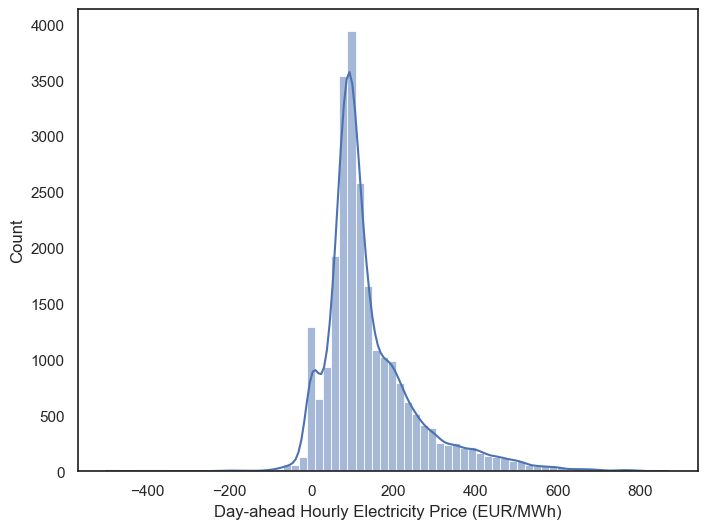

In [51]:
plt.figure(figsize=(8, 6))
# Add title and labels
# plt.title("Distribution of Day-ahead Hourly Electricity Price (Jan. 2022 - Oct. 2024)")  # Title
plt.xlabel("Day-ahead Hourly Electricity Price (EUR/MWh)")       
plt.ylabel("Count")

sns.histplot(df, x = 'price',kde=True, bins = 70)

file_name = 'histogram_kde'
plt.savefig(f'eda_plot/{file_name}.png', dpi=300, bbox_inches="tight") 

In [52]:
skewness = df['price'].skew()           # Skewness
kurtosis = df['price'].kurt()           # Kurtosis
print('s', skewness)
print('k', kurtosis)

s 1.678110116139181
k 4.166292697334381


## Corr

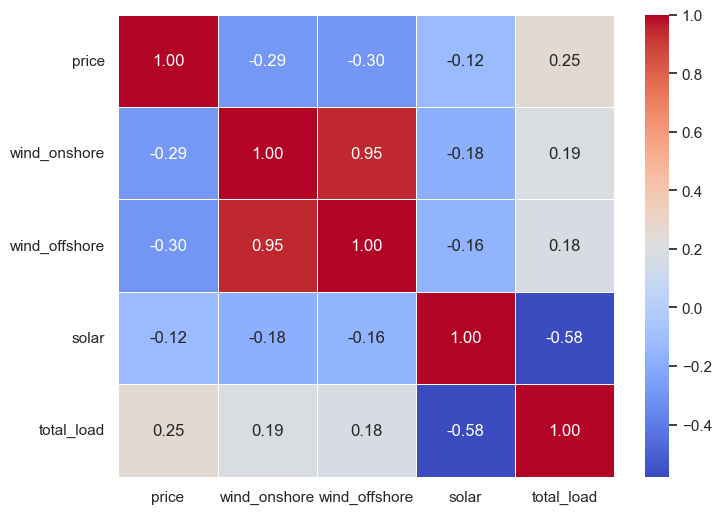

In [12]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Compute the correlation matrix
correlation_matrix = df[:['price', 'wind_onshore', 'wind_offshore', 'solar']].corr()

# Step 2: Plot the heatmap
plt.figure(figsize=(8, 6))  # Set the figure size
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
# plt.title("Correlation Heatmap")
file_name = 'corr_price'
plt.savefig(f'eda_plot/{file_name}.png', dpi=300, bbox_inches="tight") 
plt.show()

In [56]:
df[['price','wind_onshore', 'wind_offshore', 'solar']].shape

(24840, 4)

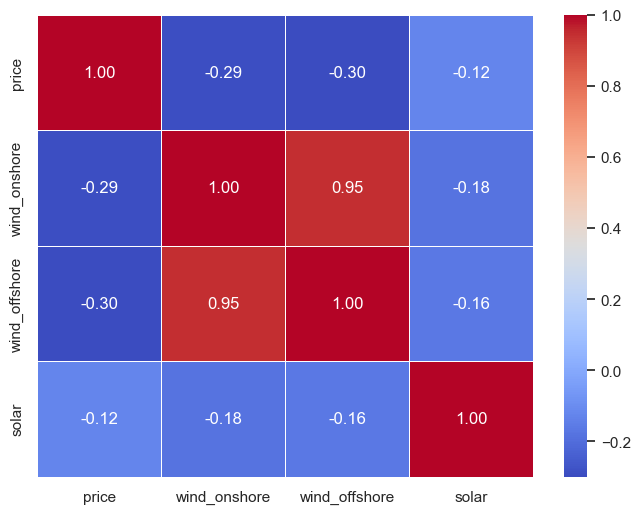

In [58]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Compute the correlation matrix
correlation_matrix = df[['price', 'wind_onshore', 'wind_offshore', 'solar']].corr()


# Step 2: Plot the heatmap
plt.figure(figsize=(8, 6))  # Set the figure size
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
# plt.title("Correlation Heatmap")
file_name = 'corr_price_new'
plt.savefig(f'eda_plot/{file_name}.png', dpi=300, bbox_inches="tight") 
plt.show()

## ADF

In [13]:
from statsmodels.tsa.stattools import adfuller

In [14]:
ADF_result = adfuller(df['price'])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -5.705832005643839
p-value: 7.492348582122063e-07


In [15]:

ADF_result = adfuller(df['wind_onshore'])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -13.97746137809548
p-value: 4.2363118238045306e-26


In [16]:
ADF_result = adfuller(df['wind_offshore'])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -14.217864651192667
p-value: 1.6776070653858486e-26


In [17]:
ADF_result = adfuller(df['solar'])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -8.130149969450656
p-value: 1.095794033699913e-12


In [18]:
ADF_result = adfuller(df['total_load'])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -11.215771346917037
p-value: 2.0715016297324e-20


## ACF & PACF

In [29]:
def save_img(file_name):
    plt.savefig(f'eda_plot/{file_name}.png', dpi=300, bbox_inches="tight") 

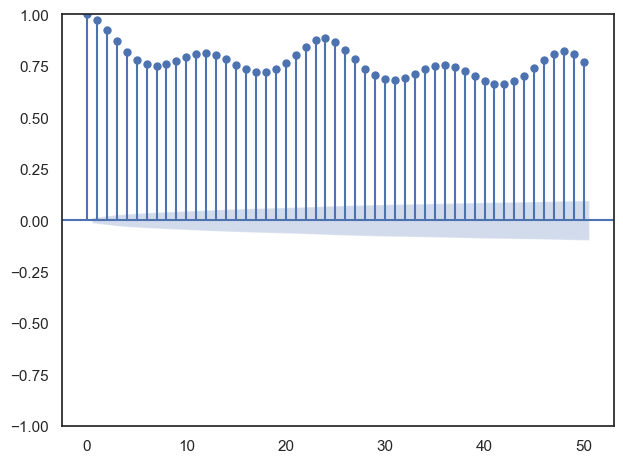

In [19]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['price'], lags=50, title=None);
plt.tight_layout()
file_name = 'acf'
plt.savefig(f'eda_plot/{file_name}.png', dpi=300, bbox_inches="tight") 

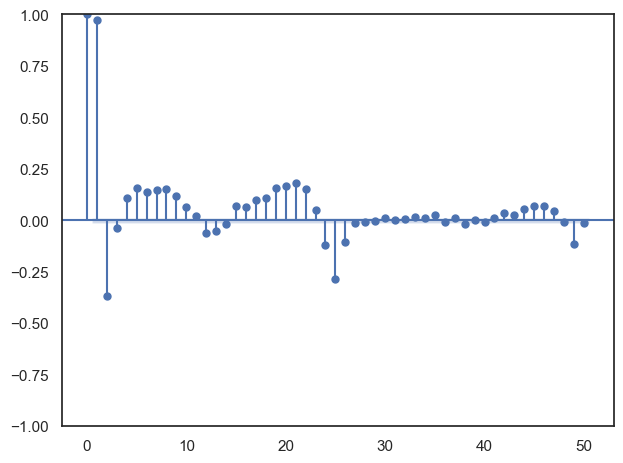

In [20]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df['price'], lags=50, title=None);
plt.tight_layout()
file_name = 'pacf'
plt.savefig(f'eda_plot/{file_name}.png', dpi=300, bbox_inches="tight") 

## E Vis

In [21]:

# Step 1: Calculate Q1, Q3, and IQR
Q1 = df['price'].quantile(0.25)  # 25th percentile
Q3 = df['price'].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1  # Interquartile range

# Step 2: Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 3: Filter out outliers
filtered_df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

print(df.describe())
print(filtered_df.describe())

              price  wind_onshore  wind_offshore         solar    total_load
count  24840.000000  24840.000000   24840.000000  24840.000000  24840.000000
mean     139.911127   6460.057850    2835.223027   4671.317190  43775.701932
std      115.040067   5468.873634    2069.218492   6773.697955   8823.738091
min     -500.000000     58.000000      17.000000      0.000000   1915.000000
25%       75.075000   1990.000000     942.000000      0.000000  39503.000000
50%      106.145000   4828.500000    2354.000000    464.000000  44155.000000
75%      180.000000   9699.000000    4769.000000   7973.500000  49150.500000
max      871.000000  25740.000000    7306.000000  31286.000000  85027.000000
              price  wind_onshore  wind_offshore         solar    total_load
count  23015.000000  23015.000000   23015.000000  23015.000000  23015.000000
mean     116.824841   6721.824636    2939.715490   4659.565197  43613.638540
std       74.318470   5547.352952    2085.910663   6793.820382   8884.511792

In [22]:
df['hour'] = df.index.hour
df['month'] = df.index.month

In [23]:
monthly_avg = df.groupby('month')['price'].mean()
hourly_avg = df.groupby('hour')['price'].mean()

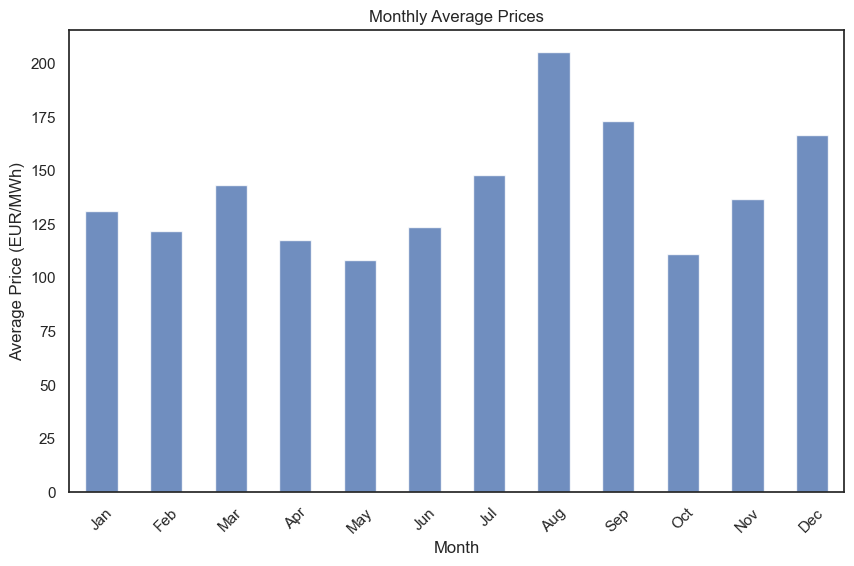

In [24]:
plt.figure(figsize=(10, 6))
monthly_avg.plot(kind='bar', alpha=0.8)
plt.title('Monthly Average Prices')
plt.xlabel('Month')
plt.ylabel('Average Price (EUR/MWh)')
plt.xticks(ticks=range(12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
], rotation=45)
# plt.grid(axis='y')
plt.show()

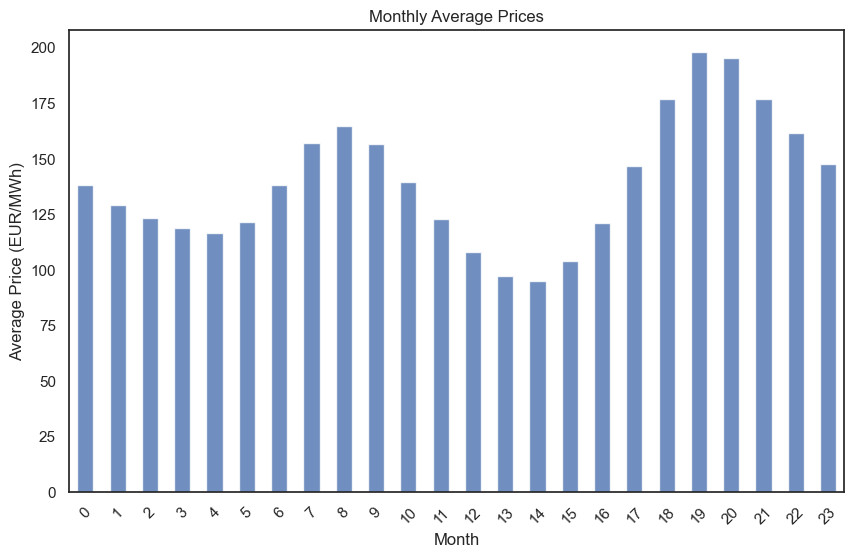

In [25]:
plt.figure(figsize=(10, 6))
hourly_avg.plot(kind='bar', alpha=0.8)
plt.title('Monthly Average Prices')
plt.xlabel('Month')
plt.ylabel('Average Price (EUR/MWh)')
plt.xticks(ticks=range(24), rotation=45)
# plt.grid(axis='y')
plt.show()

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24840 entries, 2022-01-01 01:00:00 to 2024-11-01 00:00:00
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          24840 non-null  float64
 1   wind_onshore   24840 non-null  int64  
 2   wind_offshore  24840 non-null  int64  
 3   solar          24840 non-null  int64  
 4   total_load     24840 non-null  int64  
 5   hour           24840 non-null  int32  
 6   month          24840 non-null  int32  
dtypes: float64(1), int32(2), int64(4)
memory usage: 1.3 MB


In [27]:
df['renewable_share'] = (df['wind_onshore'] + df['wind_offshore'] + df['solar']) / df['total_load'] * 100

In [39]:

df['renewable'] = df['wind_onshore'] + df['wind_offshore'] + df['solar']

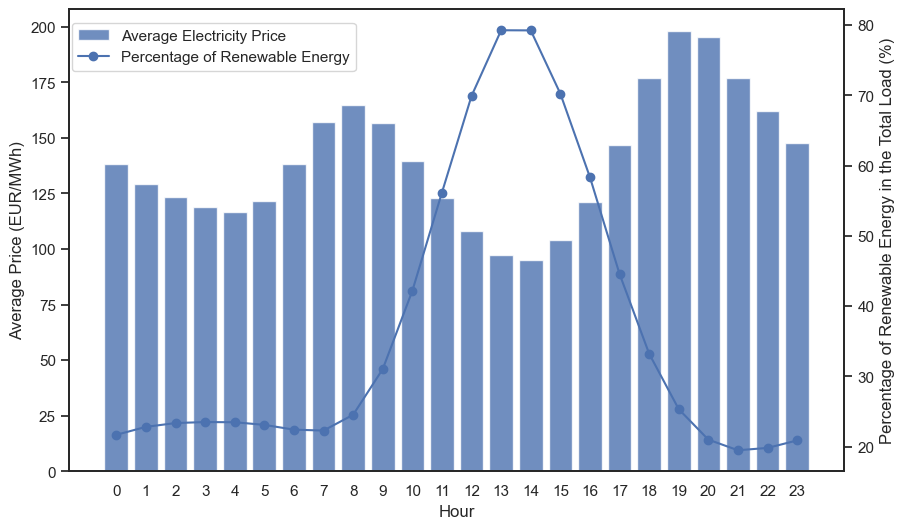

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

sns.set_style("white")
# Example data
hourly_avg_price = df.groupby('hour')['price'].mean()
renewable_avg_share = df.groupby('hour')['renewable_share'].mean()

# Step 2: Create the bar plot and overlay the line plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for price
ax1.bar(hourly_avg_price.index, hourly_avg_price.values, alpha=0.8, label='Average Electricity Price')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Average Price (EUR/MWh)')
ax1.set_xticks(range(24))
# ax1.set_xticklabels([
#     'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
#     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
# ])
ax1.tick_params(axis='y')

# Line plot for wind_onshore
ax2 = ax1.twinx()  # Create a second y-axis
ax2.plot(renewable_avg_share.index, renewable_avg_share.values,  marker='o', label='Percentage of Renewable Energy')
ax2.set_ylabel('Percentage of Renewable Energy in the Total Load (%)')
ax2.tick_params(axis='y')

# Add legend
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.87))
# plt.title('Monthly Average Price and Wind Onshore')
plt.grid(False)
save_img('hour_avg_price_renew_share')
plt.show()


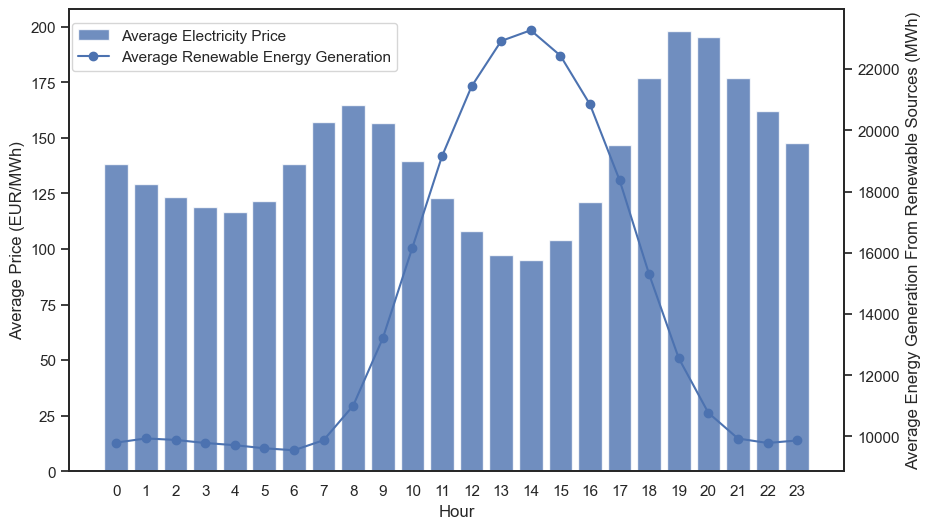

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

sns.set_style("white")
# Example data
hourly_avg_price = df.groupby('hour')['price'].mean()
renewable_avg = df.groupby('hour')['renewable'].mean()

# Step 2: Create the bar plot and overlay the line plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for price
ax1.bar(hourly_avg_price.index, hourly_avg_price.values, alpha=0.8, label='Average Electricity Price')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Average Price (EUR/MWh)')
ax1.set_xticks(range(24))
# ax1.set_xticklabels([
#     'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
#     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
# ])
ax1.tick_params(axis='y')

# Line plot for wind_onshore
ax2 = ax1.twinx()  # Create a second y-axis
ax2.plot(renewable_avg.index, renewable_avg.values,  marker='o', label='Average Renewable Energy Generation')
ax2.set_ylabel('Average Energy Generation From Renewable Sources (MWh)')
ax2.tick_params(axis='y')

# Add legend
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.87))
# plt.title('Monthly Average Price and Wind Onshore')
plt.grid(False)
save_img('hour_avg_price_renew')
plt.show()


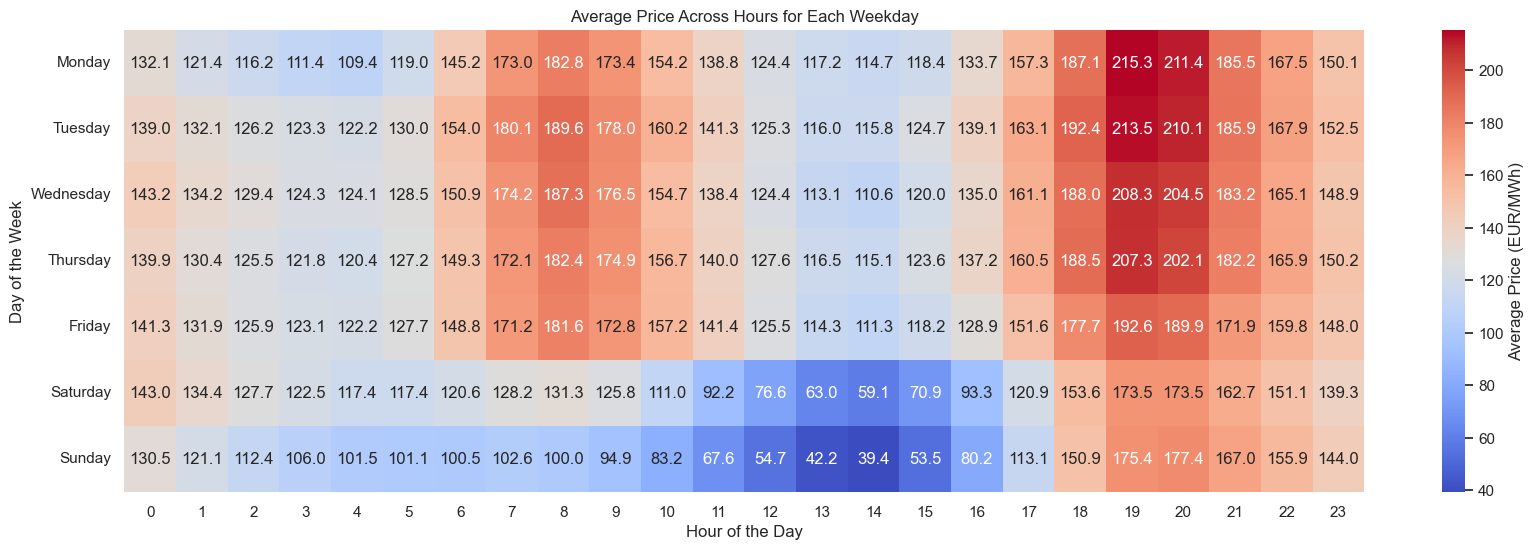

In [31]:
df['weekday'] = df.index.day_name()  # Get the day of the week
# df['hour'] = df.index.hour  # Get the hour of the day

# Calculate the average price for each weekday and hour
pivot_table = df.pivot_table(index='weekday', columns='hour', values='price', aggfunc='mean')

# Reorder the weekdays to start from Monday
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_table = pivot_table.reindex(weekday_order)

# Plot the heatmap
plt.figure(figsize=(20, 6))
sns.heatmap(pivot_table, cmap="coolwarm", annot=True, fmt=".1f", cbar_kws={'label': 'Average Price (EUR/MWh)'})
plt.title('Average Price Across Hours for Each Weekday')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
save_img('weekday_hour_price')
plt.show()

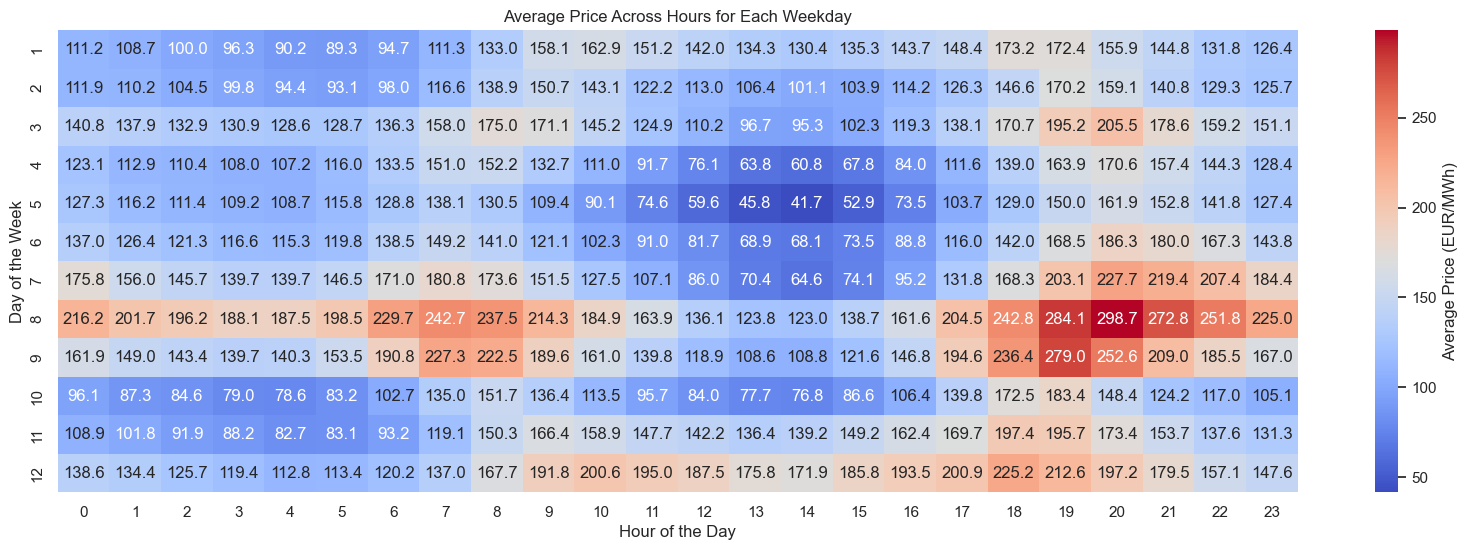

In [32]:
df['weekday'] = df.index.day_name()  # Get the day of the week
# df['hour'] = df.index.hour  # Get the hour of the day

# Calculate the average price for each weekday and hour
pivot_table = df.pivot_table(index='month', columns='hour', values='price', aggfunc='mean')

# Reorder the weekdays to start from Monday
# weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# pivot_table = pivot_table.reindex(weekday_order)

# Plot the heatmap
plt.figure(figsize=(20, 6))
sns.heatmap(pivot_table, cmap="coolwarm", annot=True, fmt=".1f", cbar_kws={'label': 'Average Price (EUR/MWh)'})
plt.title('Average Price Across Hours for Each Weekday')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
save_img('weekday_hour_price')
plt.show()

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24840 entries, 2022-01-01 01:00:00 to 2024-11-01 00:00:00
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            24840 non-null  float64
 1   wind_onshore     24840 non-null  int64  
 2   wind_offshore    24840 non-null  int64  
 3   solar            24840 non-null  int64  
 4   total_load       24840 non-null  int64  
 5   hour             24840 non-null  int32  
 6   month            24840 non-null  int32  
 7   renewable_share  24840 non-null  float64
 8   weekday          24840 non-null  object 
dtypes: float64(2), int32(2), int64(4), object(1)
memory usage: 1.7+ MB


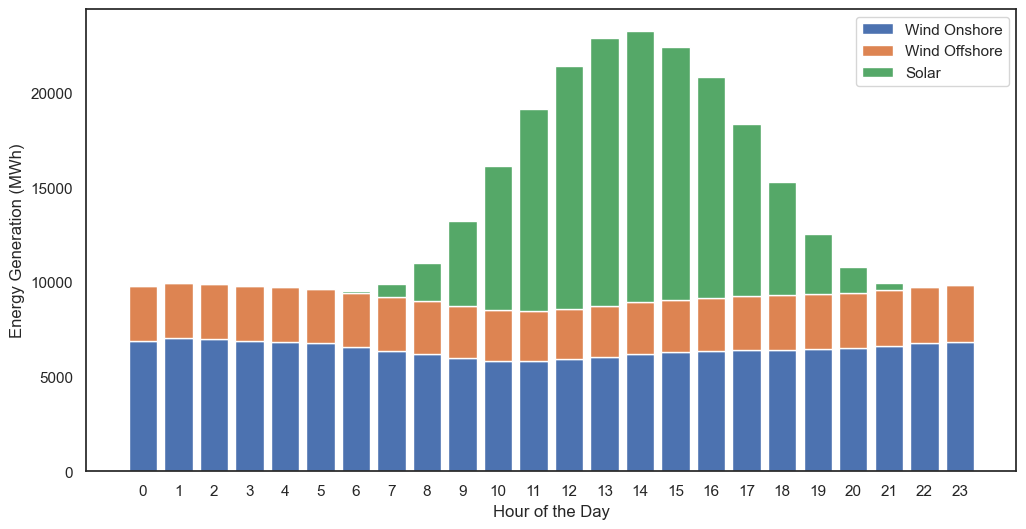

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# # Example DataFrame
# np.random.seed(42)
# date_rng = pd.date_range(start='2023-01-01', end='2023-01-07', freq='H')  # Hourly data for one week
# df = pd.DataFrame({
#     'wind_onshore': np.random.rand(len(date_rng)) * 100,
#     'wind_offshore': np.random.rand(len(date_rng)) * 80,
#     'solar': np.random.rand(len(date_rng)) * 60,
# }, index=date_rng)

# Add 'hour' column
# df['hour'] = df.index.hour

# Step 1: Group by hour and calculate the average
grouped = df.loc[:,["wind_onshore", "wind_offshore", "solar", "hour"]].groupby('hour').mean()

# Step 2: Plot the stacked bar chart
hours = grouped.index
width = 0.8  # Width of the bars

# Create the figure and axes
plt.figure(figsize=(12, 6))

# Plot each renewable energy source as a stacked layer
plt.bar(hours, grouped['wind_onshore'], width, label='Wind Onshore')
plt.bar(hours, grouped['wind_offshore'], width, bottom=grouped['wind_onshore'], label='Wind Offshore')
plt.bar(hours, grouped['solar'], width, 
        bottom=grouped['wind_onshore'] + grouped['wind_offshore'], label='Solar')

# Customize the plot
# plt.title('Stacked Bar Plot of Renewable Energy Across Hours')
plt.xlabel('Hour of the Day')
plt.ylabel('Energy Generation (MWh)')
plt.xticks(hours, range(24))  # Set x-ticks as 0–23
plt.legend()
# plt.grid(axis='y', linestyle='--', alpha=0.7)
save_img('stacked_renew')
plt.show()


In [35]:
df['total_renew'] = df['wind_onshore'] + df['wind_offshore'] + df['solar']

<Axes: ylabel='total_renew'>

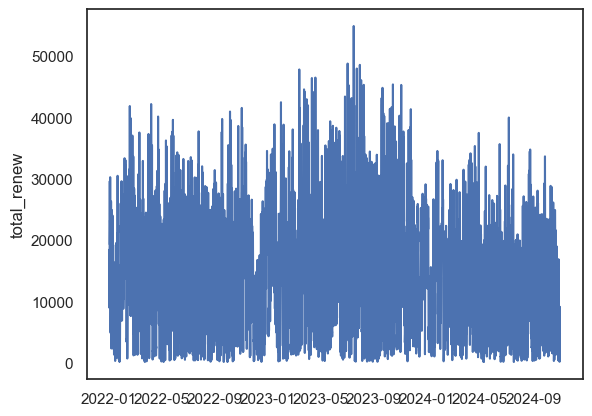

In [36]:
sns.lineplot(df['total_renew'])

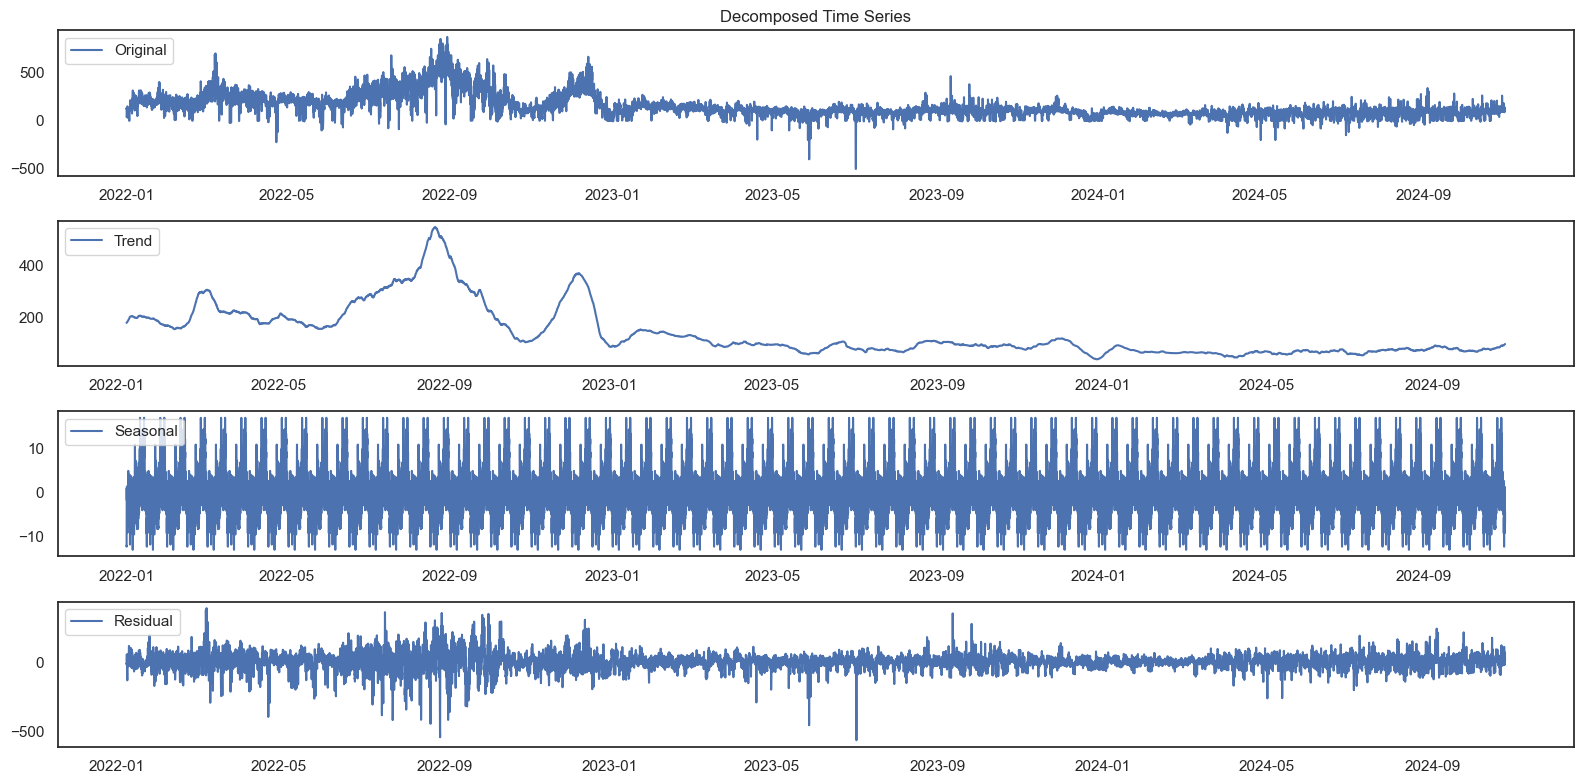

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# # Example DataFrame
# np.random.seed(42)
# date_rng = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')
# data = np.sin(2 * np.pi * date_rng.dayofyear / 365) + np.random.normal(0, 0.1, len(date_rng))  # Seasonal pattern + noise
# df = pd.DataFrame({'date': date_rng, 'value': data})
# df.set_index('date', inplace=True)

# Step 1: Decompose the time series
decomposition = seasonal_decompose(df['price'], model='additive', period=365)

# Step 2: Plot the decomposed components
plt.figure(figsize=(16, 8))

plt.subplot(4, 1, 1)
plt.plot(df['price'], label='Original')
plt.legend(loc='upper left')
plt.title('Decomposed Time Series')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()

save_img('decomposed')
plt.show()
